In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# sklearn ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

import platform
from matplotlib import font_manager, rc
#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    mpl.rcParams['axes.unicode_minus'] = False
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
        plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
#데이터 가져오기
import pandas as pd
# 데이터 경로
data_path = './cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')
print(type(submission))

print(train.shape, test.shape)

<class 'pandas.core.frame.DataFrame'>
(300000, 24) (200000, 23)


In [4]:
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [5]:
#답안은 클래스가 아니고 확률로 제출
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


In [6]:
#피처의 정보를 요약해주는 함수
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    return summary
resumetable(train)


데이터 세트 형상: (300000, 24)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [8]:
#순서형 피처 목록 확인
for i in range(3, 6):
    feature = 'ord_' + str(i)
    #문자열이 아닌 데이터를 출력하고자 하는 경우
    #f'{데이터}' 를 입력하면 됨
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'dZ' 'yN' 'Nf' 'QM' 'jV' 'sY' 'wu' 'SB'
 'UO' 'Mx' 'JX' 'Ry' 'Uk' 'uJ' 'LE' 'ps' 'kE' 'MO' 'kw' 'yY' 'zU' 'bJ'
 'Kf' 'ck' 'mb' '

In [9]:
print('day 고윳값:', train['day'].unique())
print('month 고윳값:', train['month'].unique())
print('target 고윳값:', train['target'].unique())

day 고윳값: [2 7 5 4 3 1 6]
month 고윳값: [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고윳값: [0 1]


## 시각화를 이용한 데이터 탐색

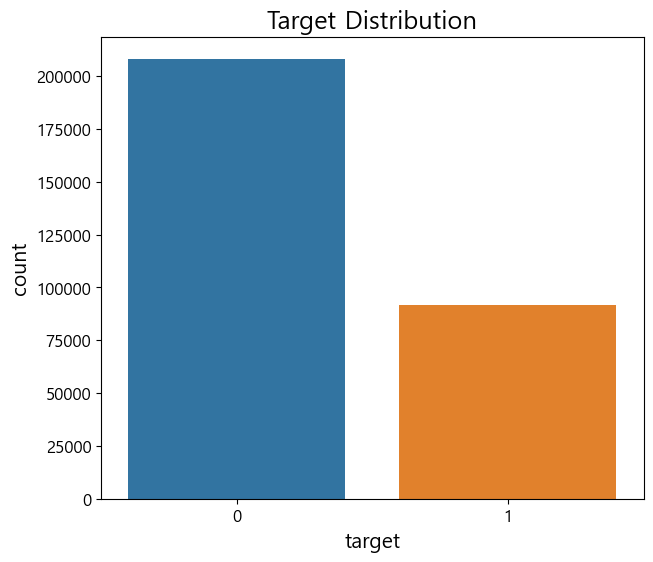

In [10]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#타겟 분포 확인
mpl.rc('font', size=15) # 폰트 크기 설정
plt.figure(figsize=(7, 6)) # Figure 크기 설정

# 타깃값 분포 카운트플롯
ax = sns.countplot(x='target', data=train)
ax.set(title='Target Distribution');

In [11]:
# 첫번째 막대에 대한 정보를 확인
rectangle = ax.patches[0]
print('사각형 높이:', rectangle.get_height())
print('사각형 너비:', rectangle.get_width())
print('사각형 왼쪽 테두리의 x축 위치:', rectangle.get_x())

사각형 높이: 208236.0
사각형 너비: 0.8
사각형 왼쪽 테두리의 x축 위치: -0.4


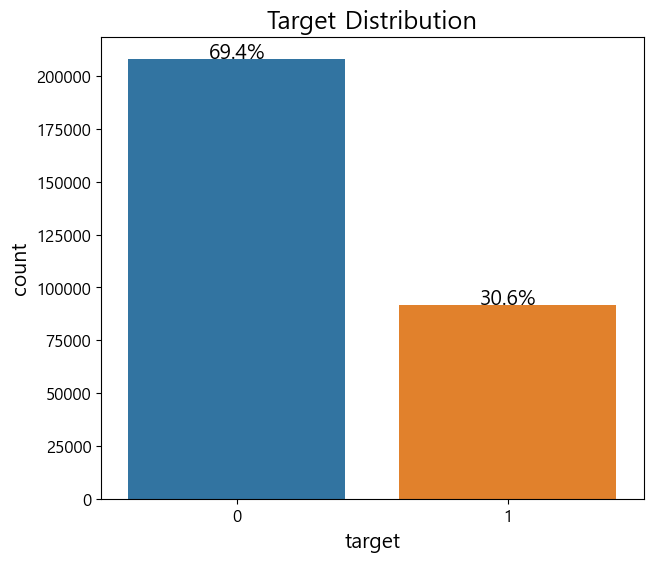

In [12]:
#텍스트 출력 - 비율을 표시
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height() # 도형 높이(데이터 개수)
        width = patch.get_width() # 도형 너비
        left_coord = patch.get_x() # 도형 왼쪽 테두리의 x축 위치
        
        percent = height/total_size*100 # 타깃값 비율
        #텍스트 출력
        ax.text(x=left_coord + width/2.0, # x축 위치
            y=height + total_size*0.001, # y축 위치
            s=f'{percent:1.1f}%', # 입력 텍스트
            ha='center') # 가운데 정렬
        
plt.figure(figsize=(7, 6))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train)) # 비율 표시
ax.set_title('Target Distribution');

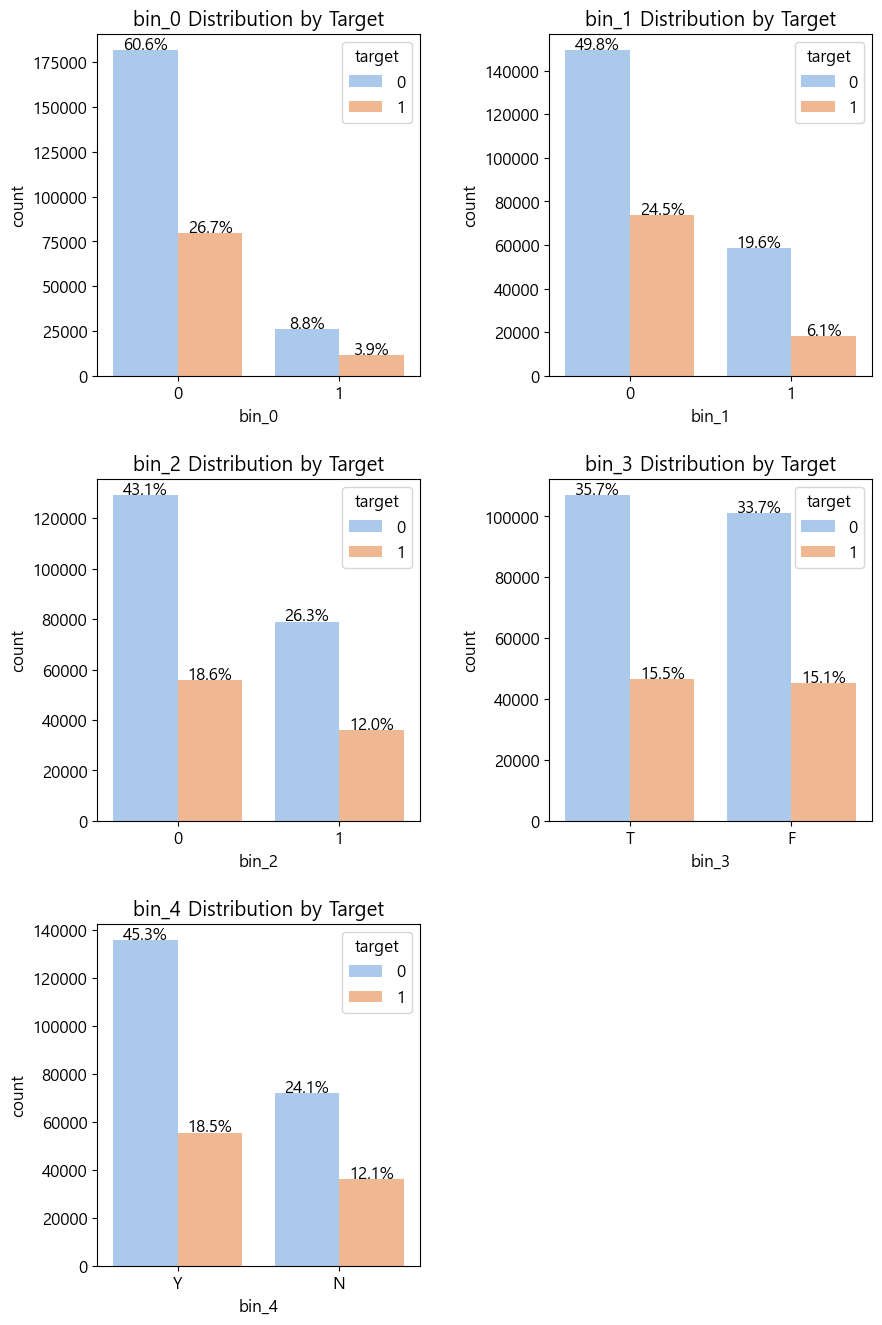

In [13]:
#여러 개의 이진 데이터 분포 확인

#여러 개의 이미지를 출력할 때 사용하는 격자
import matplotlib.gridspec as gridspec

mpl.rc('font', size=12)

grid = gridspec.GridSpec(3, 2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16)) # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

# 시각화할 컬럼 리스트
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4'] # 피처 목록

for idx, feature in enumerate(bin_features):
    ax = plt.subplot(grid[idx]) 
    
    # ax축에 타깃값 분포 카운트플롯 그리기
    sns.countplot(x=feature, 
                  data=train,
                  hue='target',
                  palette='pastel', # 그래프 색상 설정
                  ax=ax)
    
    ax.set_title(f'{feature} Distribution by Target') # 그래프 제목 설정
    write_percent(ax, len(train)) # 비율 표시


## 교차 분석

In [14]:
pd.crosstab(train['nom_0'], train['target'])

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


In [15]:
# 정규화 후 비율을 백분율로 표현
crosstab = pd.crosstab(train['nom_0'], train['target'], normalize='index')*100
crosstab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [17]:
#인덱스를 일련번호로 수정
crosstab = crosstab.reset_index() # 인덱스 재설정
crosstab 

target,index,nom_0,0,1
0,0,Blue,75.820976,24.179024
1,1,Green,67.285478,32.714522
2,2,Red,64.894827,35.105173


In [18]:
#교차 분석표를 생성하는 함수
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

crosstab = get_crosstab(train, 'nom_0')
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


## 데이터 전처리

In [19]:
print(train['ord_1'])

id
0         Grandmaster
1         Grandmaster
2              Expert
3         Grandmaster
4         Grandmaster
             ...     
299995    Contributor
299996         Novice
299997         Novice
299998         Master
299999    Contributor
Name: ord_1, Length: 300000, dtype: object


In [ ]:
#ord _1은 Novice, Contributor expert GrandMaster 슨으로 카페고리를 설정
#ord_2는 Freesing, Cold, Warm,Hot, Boiling Hot, Lava hot

In [25]:
from pandas.api.types import  CategoricalDtype


# 순서를 지정한 범주형 데이터 타입(문자열 list를 차입ㅇ러 ㄹ)
ord_1_dtype = CategoricalDtype(categories = ord_1_value, ordered = True)
ord_2_dtype = CategoricalDtype(categories = ord_2_value, ordered = True)

# 데이터 타입 변경
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

NameError: name 'ord_1_value' is not defined

# 데이터 전처리

In [26]:
#훈련 데이터와 텍스트
all_data = pd.concat([train, test]) # 훈련 데이터와 테스트 데이터 합치기
all_data = all_data.drop('target', axis=1) # 타깃값 제거
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,...,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,...,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,...,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1


In [27]:
# 범주형 데이터를 원 핫 인코딩
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() # 원-핫 인코더 생성
all_data_encoded = encoder.fit_transform(all_data) # 원-핫 인코딩 적용

In [29]:
#훈련 데이터와 테스트 데이터 분리
num_train = len(train)

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_encoded[:num_train] # 0 ~ num_train - 1행
X_test = all_data_encoded[num_train:] # num_train ~ 마지막 행
y = train['target']


MemoryError: Unable to allocate 61.7 GiB for an array with shape (500000, 16552) and data type float64

In [31]:
#훈련에 사용할 데이터와 검증을 위한 데이터 분리
from sklearn.model_selection import train_test_split

#층화 추출을 이용해서 테스트 데이터와 검증용 데이터 생성
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y,
                                                      test_size=0.3,
                                                      stratify=y,
                                                      random_state=10)

NameError: name 'X_train' is not defined

## 모델 생성 및 훈련

In [30]:
#이진 부류이므로 모든 분류기 사용 가능
from sklearn.linear_model import LogisticRegression

#모델 만들기
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
#훈련
logistic_model.fit(X_train, y_train)

NameError: name 'X_train' is not defined

## 제출할 결과 파일 생성